In [128]:
from pydrake.examples.acrobot import (AcrobotGeometry, AcrobotInput,
                                      AcrobotPlant, AcrobotState, AcrobotParams)
from pydrake.all import Linearize, LinearQuadraticRegulator, SymbolicVectorSystem, Variable, Saturation, \
WrapToSystem, Simulator

from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import LogVectorOutput

from IPython.display import SVG, display
import pydot
import numpy as np
import math
import control

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import pydrake.forwarddiff as pf
import time

In [2]:
p = AcrobotParams()

In [3]:
m1 = p.m1()
m2 = p.m2()
l1 = p.l1()
lc1 = p.lc1()
lc2 = p.lc2()
Ic1 = p.Ic1()
Ic2 = p.Ic2()
b1 = p.b1()
b2 = p.b2()
gravity = p.gravity()

In [4]:
I1 = Ic1 + m1*lc1**2
I2 = Ic2 + m2*lc2**2

In [5]:
# enter the linearized matrices
E = np.array([[1, 0, 0, 0], \
              [0, 1, 0, 0], \
              [0, 0, I1 + I2 + m2*l1**2 + 2*m2*l1*lc2, I2 + m2*l1*lc2], \
              [0, 0, I2 + m2*l1*lc2, I2]])

A = np.array([[0, 0, -1, 0], \
              [0, 0, 0, -1], \
              [-m1*gravity*lc1+m2*gravity*(-l1-lc2), -m2*gravity*lc2, b1, 0], \
              [-m2*gravity*lc2, -m2*gravity*lc2, 0, b2]])

B = np.array([[0], [0], [0], [-1]])

A = -A
B = -B

In [6]:
Q = np.diag([10, 10, 1, 1])
R = [1]

X, L, K = control.care(A, B, Q, R, E=E)

In [7]:
K

array([[-278.44223126, -112.29125985, -119.72457377,  -56.82824017]])

In [15]:
B.T@X@E

array([[-278.44223126, -112.29125985, -119.72457377,  -56.82824017]])

In [8]:
A_cloop = A-B@K
Q_lyap = np.eye(4)

P = control.lyap(A_cloop.T, Q_lyap, E = E.T)

np.linalg.eigvals(P)

array([2.10360973e+03, 2.05043095e+00, 9.98528759e-01, 7.65896243e-03])

In [129]:
# try out the controller
def UprightState():
    state = AcrobotState()
    state.set_theta1(np.pi)
    state.set_theta2(0.)
    state.set_theta1dot(0.)
    state.set_theta2dot(0.)
    return state

t1 = Variable("t1")
t2 = Variable("t2")
td1 = Variable("td1")
td2 = Variable("td2")
garbage = Variable("garbage")

x = np.hstack([t1, t2, td1, td2])
u = -K@(x  - UprightState().CopyToVector())

own_controller = SymbolicVectorSystem(state=[garbage], input=x, dynamics=np.array([0]), output=u)

M = np.array([[1, 0, 0, 0], \
              [0, 1, 0, 0], \
              [0, 0, I1 + I2 + m2*l1**2 + 2*m2*l1*lc2*pf.cos(t2), I2 + m2*l1*lc2*pf.cos(t2)], \
              [0, 0, I2 + m2*l1*lc2*pf.cos(t2), I2]])

K2 = B.T@X@M
u_new = -K2@(x - UprightState().CopyToVector())

own_controller_new = SymbolicVectorSystem(state=[garbage], input=x, dynamics=np.array([0]), output=u_new)

def acrobot_balancing_example(use_new, num_itr, plotting, max_seed):
    builder = DiagramBuilder()
    acrobot = builder.AddSystem(AcrobotPlant())

    saturation = builder.AddSystem(Saturation(min_value=[-10], max_value=[10]))
    builder.Connect(saturation.get_output_port(0), acrobot.get_input_port(0))
    wrapangles = WrapToSystem(4)
    wrapangles.set_interval(0, 0, 2. * np.pi)
    wrapangles.set_interval(1, -np.pi, np.pi)
    wrapto = builder.AddSystem(wrapangles)
    builder.Connect(acrobot.get_output_port(0), wrapto.get_input_port(0))
    
    if use_new: 
        controller = builder.AddSystem(own_controller_new)
    else:
        controller = builder.AddSystem(own_controller)
        
    builder.Connect(wrapto.get_output_port(0), controller.get_input_port(0))
    builder.Connect(controller.get_output_port(0), saturation.get_input_port(0))
    
    logger = LogVectorOutput(wrapto.get_output_port(0), builder)

#     # Setup visualization
#     scene_graph = builder.AddSystem(SceneGraph())
#     AcrobotGeometry.AddToBuilder(builder, acrobot.get_output_port(0), scene_graph)
#     meshcat.Delete()
#     meshcat.Set2dRenderMode(xmin=-4, xmax=4, ymin=-4, ymax=4)
#     MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)

    diagram = builder.Build()
    
#     simulator = Simulator(diagram)
#     context = simulator.get_mutable_context()
#     print(context)
#     display(SVG(pydot.graph_from_dot_data(
#     diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()

    # Simulate
    simulator.set_target_realtime_rate(0.0)
    duration = 8
    
    points = []
    points_failed = []
    
    seeds = np.linspace(10000, max_seed, num_itr)
    
    start_time = time.time()
    for i in range(num_itr):
        context.SetTime(0.)
        
        np.random.seed(int(seeds[i]))
        trial = np.append(UprightState().CopyToVector(), 0) + \
                                0.05 * np.random.randn(5,)
        
        context.SetContinuousState(trial)
        simulator.Initialize()
        simulator.AdvanceTo(duration)
        
        log = logger.FindLog(context)
        
        if plotting: 
            plt.figure(figsize=(5, 4))
            plt.plot(log.sample_times(), log.data().transpose())
            plt.xlabel('t')
            plt.ylabel('y(t)')
        
        teta = log.data()[0]
        avg_angle = np.average(teta[2*int(len(teta)/3):])
#         print(avg_angle)
        if  avg_angle - np.pi < 2*1e-2:
            points.append(trial[:-1])
        else: 
            points_failed.append(trial[:-1])
            
        if i%500 == 0: 
            print("Reached", str(i))
        
    run_time = start_time - time.time()
    print("Loop ended took", str(run_time))
    return points, points_failed

num_itr = 10000
plotting = False
max_seed = 20000

points, points_failed = acrobot_balancing_example(False, num_itr, plotting, max_seed)
points_new, points_failed_new = acrobot_balancing_example(True, num_itr, plotting, max_seed)

Reached 0
Reached 100
Reached 200
Reached 300
Reached 400
Reached 500
Reached 600
Reached 700
Reached 800
Reached 900
Reached 1000
Reached 1100
Reached 1200
Reached 1300
Reached 1400
Reached 1500
Reached 1600
Reached 1700
Reached 1800
Reached 1900
Reached 2000
Reached 2100
Reached 2200
Reached 2300
Reached 2400
Reached 2500
Reached 2600
Reached 2700
Reached 2800
Reached 2900
Reached 3000
Reached 3100
Reached 3200
Reached 3300
Reached 3400
Reached 3500
Reached 3600
Reached 3700
Reached 3800
Reached 3900
Reached 4000
Reached 4100
Reached 4200
Reached 4300
Reached 4400
Reached 4500
Reached 4600
Reached 4700
Reached 4800
Reached 4900
Reached 5000
Reached 5100
Reached 5200
Reached 5300
Reached 5400
Reached 5500
Reached 5600
Reached 5700
Reached 5800
Reached 5900
Reached 6000
Reached 6100
Reached 6200
Reached 6300
Reached 6400
Reached 6500
Reached 6600
Reached 6700
Reached 6800
Reached 6900
Reached 7000
Reached 7100
Reached 7200
Reached 7300
Reached 7400
Reached 7500
Reached 7600
Reached 770

In [130]:
points_failed = np.array(points_failed)
points = np.array(points)
points_new = np.array(points_new)
points_failed_new = np.array(points_failed_new)

In [131]:
len(points)

9042

In [132]:
len(points_new)

9291

<IPython.core.display.Javascript object>


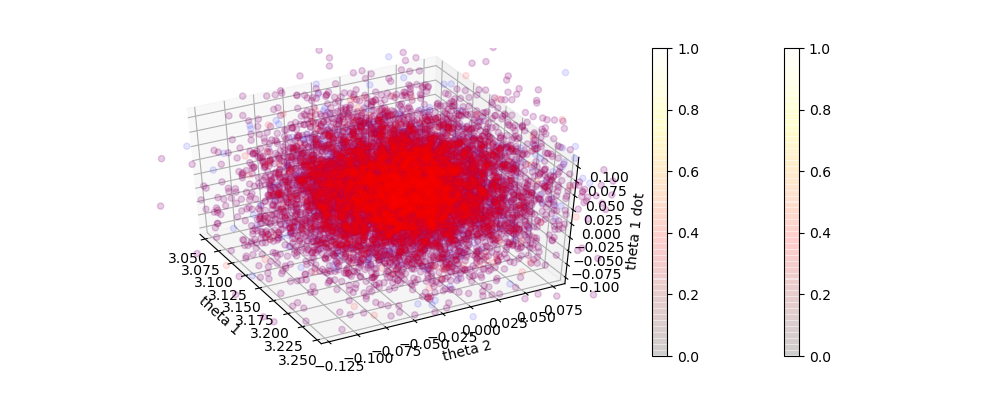

Text(0.5, 0, 'theta 1 dot')

In [141]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111, projection='3d')

# img = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c = points[:, 3], marker='x', cmap='viridis')
# fig.colorbar(img)

# img2 = ax.scatter(points_new[:, 0], points_new[:, 1], points_new[:, 2], \
#                   c = points_new[:, 3], marker='o', cmap = plt.hot())
# fig.colorbar(img2)
img2 = ax.scatter(points_new[:, 0], points_new[:, 1], points_new[:, 2], \
                  c = 'b', marker='o', alpha=0.1)
fig.colorbar(img2)
img = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c = 'r', marker='o', alpha = 0.1)
fig.colorbar(img)



ax.set_xlabel("theta 1")
ax.set_ylabel("theta 2")
ax.set_zlabel("theta 1 dot")

In [103]:
UprightState().CopyToVector() + 0.05 * np.random.randn(4,)

array([ 3.09582565,  0.00313207, -0.08825696,  0.07258637])

In [15]:
ACRO = AcrobotPlant()

In [16]:
def UprightState():
    state = AcrobotState()
    state.set_theta1(np.pi)
    state.set_theta2(0.)
    state.set_theta1dot(0.)
    state.set_theta2dot(0.)
    return state

context = ACRO.CreateDefaultContext()
input = AcrobotInput()
input.set_tau(0)
ACRO.get_input_port(0).FixValue(context, input)

context.get_mutable_continuous_state_vector().SetFromVector(UprightState().CopyToVector())

In [17]:
linearized_acro = Linearize(ACRO, context)

LQR = LinearQuadraticRegulator(linearized_acro.A(), linearized_acro.B(), Q, R)

In [18]:
LQR

(array([[-278.44223126, -112.29125985, -119.72457377,  -56.82824017]]),
 array([[16620.60660543,  7470.1873401 ,  7240.12368147,  3571.58116271],
        [ 7470.1873401 ,  3374.43640793,  3256.40272521,  1608.54161654],
        [ 7240.12368147,  3256.40272521,  3154.73036214,  1556.50607291],
        [ 3571.58116271,  1608.54161654,  1556.50607291,   768.33308414]]))

In [45]:
c = ACRO.get_mutable_state(context)

In [49]:
d = ACRO.get_state(context)

In [52]:
type(d)

pydrake.examples.acrobot.AcrobotState

In [53]:
type(c)

pydrake.examples.acrobot.AcrobotState

Getting Lyapunov function from closed loop controller